### Titanic Survival Analysis

In [85]:
#data imports
import numpy as np
import pandas as pd
from pandas import DataFrame, Series

#math
import math

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#machine learning imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

#evaluation of ML results
from sklearn import metrics

#statsmodels
import statsmodels.api as sm

## Data Load and Variable Overview

In [2]:
titanic_df=pd.read_csv('titanic.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Variable Information

Variable	Definition	Key

survival	Survival	0 = No, 1 = Yes

pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd

sex	Sex	

Age	Age in years	

sibsp	# of siblings / spouses aboard the Titanic	

parch	# of parents / children aboard the Titanic	

ticket	Ticket number	

fare	Passenger fare	

cabin	Cabin number	

embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

In [3]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Here we can see that in total we have data on 891 passengers of Titanic. Our target variable is Survived, as we'll look into what effected the chances of survival of Titanic disaster.

## Missing Values

From variable information we can already see some missing values. Quite many in Cabin, some in Age and few in Embarked. So what can be dome with them?

In the case of Embarked, as there are only two missings, I decided to fill them with most common port of embarkation.

In the case of Cabin, where we have vast majority of values missing, I decided to leave them as they are. It would be too risky to try to supplement the values, as there is not that many cases to operate with.

The case of Age is rather interesting. Because it will be one of important variables to explain whether person survived or not. The best practice would be to fill it with the most accurate value, based on other variables, and that's why I need to look bit more in depth to this.

In [5]:
#for Embarked - let's just use the most common value
most_embarked=titanic_df.Embarked.value_counts().index[0]

titanic_df.Embarked=titanic_df.Embarked.fillna(most_embarked)

In [6]:
#let's look into how Age medians vary between Sex and Pclass
grouped_age=titanic_df.groupby(['Sex','Pclass']).Age.median()
grouped_age

Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64

As we can see here, medians within each class by gender gives us some view on age structure. We can assign these medians to missing values. Even though we are kind of dismissing the option of children as missing values, this is still more accurate then just filling them with general mean value.

In [12]:
#let's give them medians of gender and class
titanic_df.loc[titanic_df.Age.isnull(), 'Age'] = titanic_df.groupby(['Sex','Pclass']).Age.transform('median')

In [13]:
#checking that we have missing values filled, with exception of Cabin
titanic_df.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked       False
Person         False
dtype: bool

## Outliers

Similarly as with missing values, we should check for outliers in our categorical values - Age and Fare.

Text(0.5, 1.0, 'Histogram of Age')

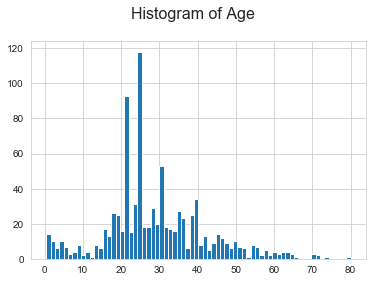

In [16]:
#checking the structure of Age
titanic_df['Age'].hist(bins=70)
plt.suptitle('Histogram of Age', y=1., fontsize = 16)

Text(0.5, 1.0, 'Boxplot of Age')

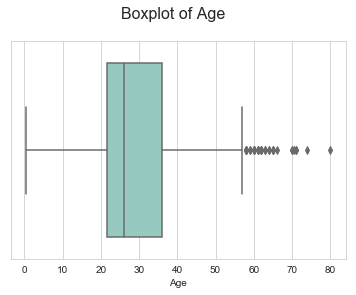

In [17]:
#boxplot of Age
sns.boxplot(titanic_df['Age'], palette="Set3")
plt.suptitle("Boxplot of Age", y=1., fontsize = 16)

I don't see any reason why to leave older people out of our analysis, even their story might be interesting when we look into combination of survival and age.

Text(0.5, 1.0, 'Boxplot of Fare')

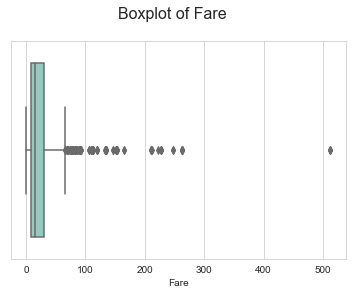

In [18]:
#boxplot of Fare
sns.boxplot(titanic_df['Fare'], palette="Set3")
plt.suptitle("Boxplot of Fare", y=1., fontsize = 16)

In [19]:
#let's look into those tickets over 500
titanic_df[titanic_df['Fare']>500]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,female
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,male
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,male


Not surprisingly, those who paid the most were in the 1st class, interestingly they all survived. This is information, that I definitely don't want to lose, thus I am leaving them in my analysis, but I am aware that they are fairly specific.

## Average Survival Rate

was only **38.38%**, so only bit over third of passengers survived.

In [20]:
#as Survived is simply 0/1, average survival will be
titanic_df['Survived'].mean()*100

38.38383838383838

In [21]:
#creating categorical variable Survivor
titanic_df['Survivor']=titanic_df.Survived.map({0:'No',1:'Yes'})
titanic_df.Survivor.value_counts()

No     549
Yes    342
Name: Survivor, dtype: int64

Text(0.5, 1.0, 'Number of Titanic Casualties')

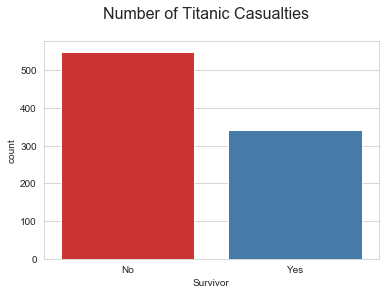

In [22]:
#let's see it in the plot
sns.countplot('Survivor',data=titanic_df,palette='Set1')
plt.suptitle('Number of Titanic Casualties', y=1., fontsize = 16)

## Important Surviving Factors

Some factors were likely more influential for survival, so we should look into what those are.

We can assume than gender was important factor, together with age, class and also fare.

We all know saying 'Women and children first!', so we should seperate children from general sex variable to see how this rule played out.

In [23]:
#creating variable to track also children
def female_male_child (passenger):
    age,sex=passenger
    if age<16:
        return 'child'
    else:
        return sex

#applying the function
titanic_df['Person']=titanic_df[['Age','Sex']].apply(female_male_child,
                                                    axis=1)
titanic_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person,Survivor
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,male,No
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female,Yes
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female,Yes
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female,Yes
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,male,No
5,6,0,3,"Moran, Mr. James",male,25.0,0,0,330877,8.4583,NaN,Q,male,No
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,male,No
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,child,No
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,female,Yes
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,child,Yes


**Sex and Survival**

Text(0.5, 1.0, 'Number of Titanic Casualties by Sex')

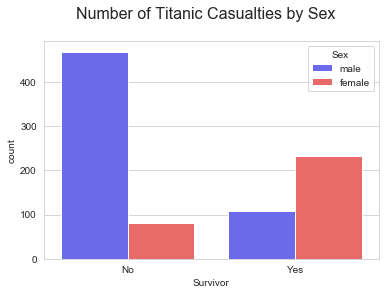

In [27]:
#simple plot of Sex and Survivor
sns.countplot('Survivor',data=titanic_df,palette='seismic',hue='Sex')
plt.suptitle('Number of Titanic Casualties by Sex', y=1., fontsize = 16)

Here is already quite visible, that women survived in higher rates than men.

Text(0.5, 1.0, 'Number of Titanic Casualties by Group')

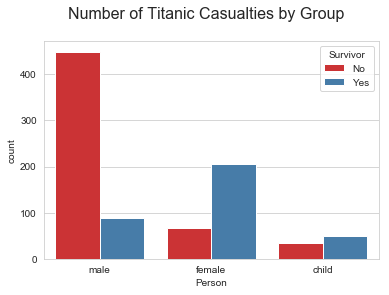

In [28]:
sns.countplot('Person',data=titanic_df,palette='Set1',hue='Survivor')
plt.suptitle('Number of Titanic Casualties by Group', y=1., fontsize = 16)

In [29]:
#let's define fmch f=0 m=1 ch=2, so we can calculate survival rate
titanic_df['Fmch']=titanic_df.Person.map({'female':0,'male':1,'child':2})

In [30]:
#survival rate of children
(titanic_df.loc[titanic_df.Fmch==2,'Survived'].sum())/((titanic_df.loc[titanic_df.Fmch==2,'Survived'].count()))*100

59.036144578313255

In [31]:
#survival rate of women
(titanic_df.loc[titanic_df.Fmch==0,'Survived'].sum())/((titanic_df.loc[titanic_df.Fmch==0,'Survived'].count()))*100

75.64575645756457

In [32]:
#survival rate of men
(titanic_df.loc[titanic_df.Fmch==1,'Survived'].sum())/((titanic_df.loc[titanic_df.Fmch==1,'Survived'].count()))*100

16.387337057728118

Here we can quite clearly see that best chances on surviving had **women (76%)**, then **children (59%)**, and the worst chances had **men (16%)**.

We can already say, that 'Women and children first!' rule definitely played significant role.

**Class and Survival**

Text(0.5, 1.0, 'Count of Titanic Casualties by Class')

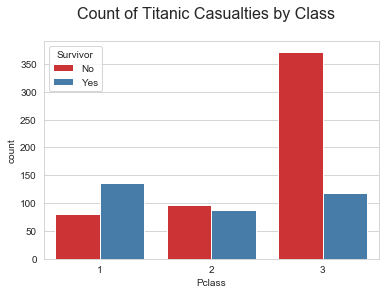

In [33]:
#let's look into classes
sns.countplot('Pclass',data=titanic_df,palette='Set1',hue='Survivor')
plt.suptitle('Count of Titanic Casualties by Class', y=1., fontsize = 16)

In [34]:
#survival rate of 1st class
(titanic_df.loc[titanic_df.Pclass==1,'Survived'].sum())/((titanic_df.loc[titanic_df.Pclass==1,'Survived'].count()))*100

62.96296296296296

In [35]:
#survival rate of 2nd class
(titanic_df.loc[titanic_df.Pclass==2,'Survived'].sum())/((titanic_df.loc[titanic_df.Pclass==2,'Survived'].count()))*100

47.28260869565217

In [36]:
#survival rate of 3rd class
(titanic_df.loc[titanic_df.Pclass==3,'Survived'].sum())/((titanic_df.loc[titanic_df.Pclass==3,'Survived'].count()))*100

24.236252545824847

Social inequality also played a big role in chances of survival. Those who traveled in better classes had higher rates of survival. The highest rate of survival had those who travelled in **1st class (63%)**, followed by **2nd class (47%)**, the worst survival rate had passengers travelling in **3rd class (24%)**.


**Survival by Age, Sex and Class**

Text(0.5, 1.0, 'Number of Passengers by Class and Group')

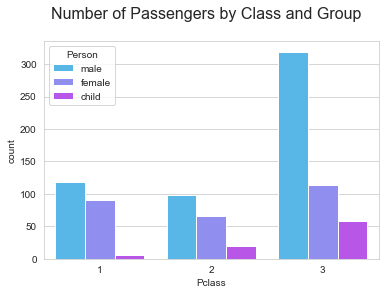

In [45]:
#let's look who travelled in which class first
sns.countplot('Pclass',data=titanic_df,hue='Person', palette='cool')
plt.suptitle('Number of Passengers by Class and Group', y=1., fontsize = 16)

We can already see that most men were travelling in 3rd class, thus connection of survival, class and sex is more intertwined. Another interesting fact is that also majority of children travelled in 3rd class.

Text(0.5, 1.1, 'Survivors and Casualties by Class and Group')

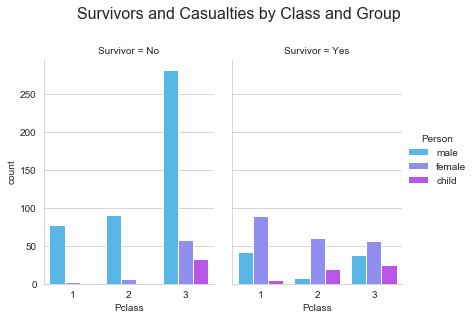

In [47]:
#connection of sex, gender and class to survival
sns.catplot(x="Pclass", hue="Person", col="Survivor", palette='cool',
            data=titanic_df, kind="count", height=4, aspect=.7)
plt.suptitle('Survivors and Casualties by Class and Group', y=1.1, fontsize = 16)

In this figure we can see quite clearly, that regardless of class, men had the lowest survival rates out of all categories. Most men also faced double disadvantage, one solely by being men, another by the fact that majority of them was also travelling in 3rd class. The biggest proportion of women and children that did not survived was among those travelling in 3rd class.

**Port of Embarkation and Survival**

Text(0.5, 1.0, 'Survivors and Casualties by Embarked Port')

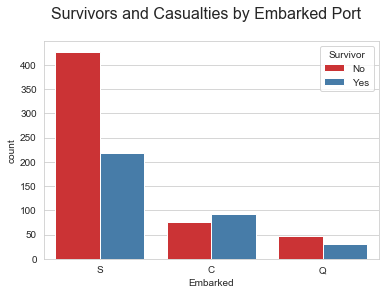

In [48]:
sns.countplot('Embarked',data=titanic_df,palette='Set1',hue='Survivor')
plt.suptitle('Survivors and Casualties by Embarked Port', y=1., fontsize = 16)

Majority of people embarked in Southampton, passengers that embarked there ended up with highest proportion of casualties then in Queenstown. Paddangers that borded in Cherbourg ended up with highest survival rate.

Text(0.5, 1.0, 'Number of Passengers by Class and Port of Embarktion')

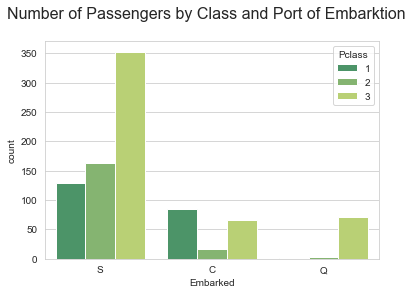

In [51]:
#let's check which classes embarked in which port
sns.countplot('Embarked',data=titanic_df,palette='summer',hue='Pclass')
plt.suptitle('Number of Passengers by Class and Port of Embarktion', y=1., fontsize = 16)

Passengers that boarded in Southampton were quite frequently those, who travelled in 3rd class, which partially explains the lowest survival rate. Another rather interesting fact is that passengers that boarded in Queenstown were almost exclusively those travelling with 3rd class.

**Deck and Survival**

Even though we have plenty of missings, we can at least look briefly into survival rate of different decks, as for some people was location of their cabin less fortunate than for others. We can extract this information from  the first letter of variable Cabin.

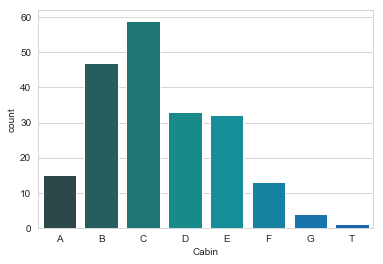

In [53]:
Deck=titanic_df['Cabin'].dropna()

#creating new variable from 1st letter in cabin - using for loop
levels=[]

for level in Deck:
    levels.append(level[0])
    
cabin_df=DataFrame(levels)

cabin_df.columns=['Cabin']

#checking the counts of Cabins
sns.countplot('Cabin',data=cabin_df, 
              order=['A','B','C','D','E','F','G','T'],palette='winter_d')

Text(0.5, 1.07, 'Survivors and Casualties by Deck')

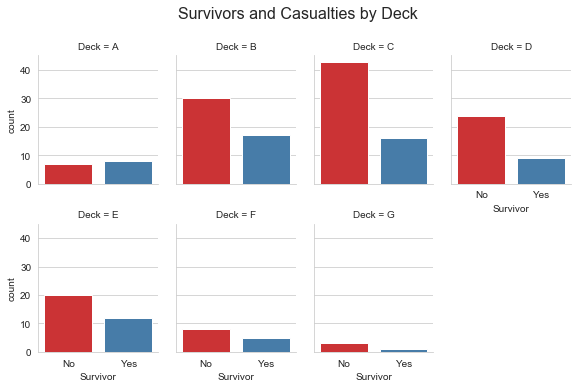

In [56]:
#not including T as it's unknown deck
cabin_df=cabin_df[cabin_df.Cabin !='T']

#attaching Deck to titanic_df dataframe
titanic_df['Deck']=cabin_df.Cabin

#plotting decks with survivors
sns.catplot('Survivor', col='Deck', col_wrap=4,data=titanic_df, kind='count',
           height=2.5, aspect=.8, palette='Set1',
           col_order=['A','B','C','D','E','F','G'])
plt.suptitle('Survivors and Casualties by Deck', y=1.07, fontsize = 16)

Even though there were differences between decks, results do not seem to show any pattern. In combination with nummber of missing values here, it's better to move to other variables.

**Age and Survival**

As we somehow witnessed while looking at different survival rates of men, women, and children, age seems to be important factor of one's survival.

This fact is also visible in plot of regression bellow -  older the passengers were, less likely they survived the crush.

Text(0.5, 1.07, 'Relationship between Survival and Age')

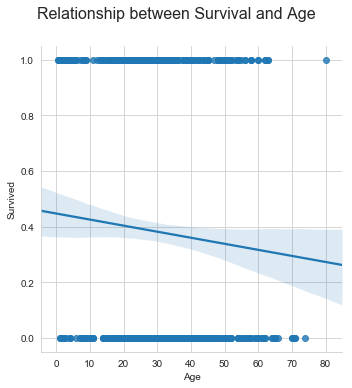

In [58]:
#regression plot of Age and Survived
sns.lmplot('Age','Survived',data=titanic_df, palette='winter')
plt.suptitle('Relationship between Survival and Age', y=1.07, fontsize = 16)

**Survival by Age and Class**

Text(0.5, 1.07, 'Relationship between Survival, Age and Class')

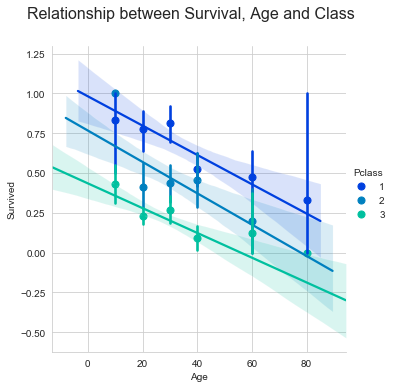

In [59]:
#let's use bins so we see data more clearly
generations=[10,20,30,40,60,80]

#plot of survival by age and travel classes
sns.lmplot('Age','Survived',hue='Pclass',data=titanic_df,palette='winter',
          x_bins=generations)
plt.suptitle('Relationship between Survival, Age and Class', y=1.07, fontsize = 16)

We can observe that all ages had better chances in higher travel classes. There was also pretty high standard deviation in old peoples group.

**Survival by Age and Sex**

We already know that both age and sex were important factors of survival, but how they work combined?

Text(0.5, 1.07, 'Relationship between Survival, Age and Sex')

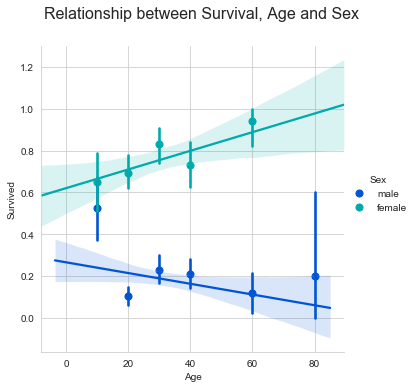

In [60]:
#plot of combination of age and sex
sns.lmplot('Age','Survived',hue='Sex',data=titanic_df,palette='winter',
          x_bins=generations)
plt.suptitle('Relationship between Survival, Age and Sex', y=1.07, fontsize = 16)

Here we see quite a the paradox - women were more likely to survived older they got, yet for men it was the other way around.

**Fare and Survival**

Could one buy a survival on Titanic?

It's quite visible that those with better tickets were more likely to survive.

Text(0.5, 1.07, 'Relationship between Survival and Fare')

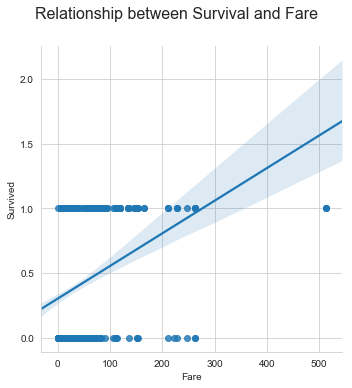

In [61]:
#what about fare? could one buy a 'survival'
sns.lmplot('Fare','Survived',data=titanic_df,palette='winter')
plt.suptitle('Relationship between Survival and Fare', y=1.07, fontsize = 16)

## Correlation of factors

In [62]:
#let's check data again
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Person,Survivor,Fmch,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,male,No,1,C
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,female,Yes,0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,female,Yes,0,E
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,female,Yes,0,G
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,male,No,1,C


In [64]:
#and let's drop some variables
titanic_df=titanic_df.drop(['PassengerId','Name','Ticket'],
                              axis=1)

In [65]:
#some initial correlations
corr=titanic_df.corr()
corr

,Survived,Pclass,Age,SibSp,Parch,Fare,Fmch
Survived,1.000000,-0.338481,-0.059579,-0.035322,0.081629,0.257307,-0.325753
Pclass,-0.338481,1.000000,-0.413583,0.083081,0.018443,-0.549500,0.196793
Age,-0.059579,-0.413583,1.000000,-0.249854,-0.175526,0.122692,-0.319483
SibSp,-0.035322,0.083081,-0.249854,1.000000,0.414838,0.159651,0.136003
Parch,0.081629,0.018443,-0.175526,0.414838,1.000000,0.216225,0.055682
Fare,0.257307,-0.549500,0.122692,0.159651,0.216225,1.000000,-0.146290
Fmch,-0.325753,0.196793,-0.319483,0.136003,0.055682,-0.146290,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

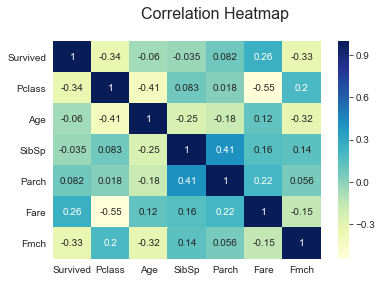

In [66]:
#heatmap
sns.heatmap(corr,annot=True, cbar=True, cmap='YlGnBu')
plt.suptitle('Correlation Heatmap', y=1.0, fontsize = 16)

Here we can see correlations of numerical variables between each other. If we focus on survival, we can see that the strongest correlation survival has with travel class, followed by fare. There is also some relation with our numerical variable of female/male/child variable, but as it is still categorical and not ordeed, it's not correct to just only on the base of correlation coefficient.

Next step is to create regression model with dummy variables, that will help us to see how strong is the relationship with our target variable.

## Logistic Regression

In [74]:
#let's check our dataset again
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Person,Survivor,Fmch,Deck
0,0,3,male,22.0,1,0,7.2500,NaN,S,male,No,1,C
1,1,1,female,38.0,1,0,71.2833,C85,C,female,Yes,0,C
2,1,3,female,26.0,0,0,7.9250,NaN,S,female,Yes,0,E
3,1,1,female,35.0,1,0,53.1000,C123,S,female,Yes,0,G
4,0,3,male,35.0,0,0,8.0500,NaN,S,male,No,1,C


In [75]:
#creating dummy variables from categorical Pclass, Person, Embarked
pclass_dumm = pd.get_dummies(titanic_df.Pclass, prefix='Pclass')
person_dumm = pd.get_dummies(titanic_df.Person, prefix='Person')
embarked_dumm = pd.get_dummies(titanic_df.Embarked, prefix='Embarked')

In [76]:
#concatenate dummy columns with main dataset
titanic_dumm = pd.concat([titanic_df, pclass_dumm, person_dumm, 
                              embarked_dumm], axis=1)
titanic_dumm.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Person,...,Deck,Pclass_1,Pclass_2,Pclass_3,Person_child,Person_female,Person_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,male,22.0,1,0,7.2500,NaN,S,male,...,C,0,0,1,0,0,1,0,0,1
1,1,1,female,38.0,1,0,71.2833,C85,C,female,...,C,1,0,0,0,1,0,1,0,0
2,1,3,female,26.0,0,0,7.9250,NaN,S,female,...,E,0,0,1,0,1,0,0,0,1
3,1,1,female,35.0,1,0,53.1000,C123,S,female,...,G,1,0,0,0,1,0,0,0,1
4,0,3,male,35.0,0,0,8.0500,NaN,S,male,...,C,0,0,1,0,0,1,0,0,1


In [77]:
#dropping categorical fields: Pclass, Person, Embarked, Sex, Deck, Survivor
#fields I don't want in my model: Fmch, Cabin
#target variable: Survived
titanic_dumm.drop(['Pclass', 'Person','Sex', 'Cabin', 'Embarked',
                   'Survived', 'Fmch', 'Deck', 'Survivor'],
                  axis=1, inplace=True)

titanic_dumm.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Person_child,Person_female,Person_male,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,0,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,1,0,0,0,1,0,1,0,0
2,26.0,0,0,7.9250,0,0,1,0,1,0,0,0,1
3,35.0,1,0,53.1000,1,0,0,0,1,0,0,0,1
4,35.0,0,0,8.0500,0,0,1,0,0,1,0,0,1


In [78]:
#taking care of multicollinearity
#dropping Person_male, Pclass_3, Embarked_S
titanic_dumm=titanic_dumm.drop(['Person_male','Pclass_3','Embarked_S'],
                              axis=1)

titanic_dumm.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Person_child,Person_female,Embarked_C,Embarked_Q
0,22.0,1,0,7.2500,0,0,0,0,0,0
1,38.0,1,0,71.2833,1,0,0,1,1,0
2,26.0,0,0,7.9250,0,0,0,1,0,0
3,35.0,1,0,53.1000,1,0,0,1,0,0
4,35.0,0,0,8.0500,0,0,0,0,0,0


I am dropping one class of dummy variables, because otherwise those dummy variables would be highly correlated with one another (where one has 1 others have 0), which would negatively affect the model.

In [79]:
#setting target
Y=titanic_df.Survived
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [80]:
#flattening of Y array
Y = np.ravel(Y)

Y[:10]

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1], dtype=int64)

In [81]:
#creating LogisticRegression model
log_model = LogisticRegression()

#fitting data
log_model.fit(titanic_dumm,Y)

#checking accuracy
log_model.score(titanic_dumm,Y)
#accuracy rating is 83,05%

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8305274971941639

In [82]:
#null error rate
1-Y.mean()

0.6161616161616161

As our target variable is 0/1, mean can tell us null error rate - if model would simply guessed that everyone on Titanic died, the accuracy would be 61.6%. Our model is better in predicting survival.

**Coefficients and odds ratios**

In [86]:
titanic_dumm['intercept']=1.0
titanic_dumm.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Person_child,Person_female,Embarked_C,Embarked_Q,intercept
0,22.0,1,0,7.2500,0,0,0,0,0,0,1.0
1,38.0,1,0,71.2833,1,0,0,1,1,0,1.0
2,26.0,0,0,7.9250,0,0,0,1,0,0,1.0
3,35.0,1,0,53.1000,1,0,0,1,0,0,1.0
4,35.0,0,0,8.0500,0,0,0,0,0,0,1.0


In [88]:
#assigning what columns to use
titanic_cols=titanic_dumm.columns[:]
titanic_cols

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_1', 'Pclass_2', 'Person_child',
       'Person_female', 'Embarked_C', 'Embarked_Q', 'intercept'],
      dtype='object')

In [89]:
#creating model
logit=sm.Logit(titanic_df['Survived'],titanic_dumm[titanic_cols])

In [90]:
#results
result=logit.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.417635
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      880
Method:                           MLE   Df Model:                           10
Date:                Fri, 22 Mar 2019   Pseudo R-squ.:                  0.3728
Time:                        14:49:21   Log-Likelihood:                -372.11
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 8.602e-89
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age              -0.0249      0.010     -2.548      0.011      -0.044      -0.006
SibSp            -0.4899      0.117     -4.179      0.000      -0.720      -0.260
Parch            -0.2458      0.129     -1.899      0.058      -0.499       0.008
Fare              0.0028      0.003      1.093      0.274      -0.002       0.008
Pclass_1          2.2028      0.325      6.769      0.000       1.565       2.841
Pclass_2          1.1594      0.250      4.644      0.000       0.670       1.649
Person_child      2.9906      0.430      6.957      0.000       2.148       3.833
Person_female     3.1668      0.228     13.860      0.000       2.719       3.615
Embarked_C        0.4188      0.248      1.691      0.091      -0.066       0.904
Embarked_Q        0.1549      0.344      0.450      0.653      -0.520       0.830
intercept        -1.8028      0.332     -5.438      0.000      -2.453      -1.153
=================================================================================
"""

From the summary table we can observe, that there were couple of not significant variables in our model. On the P value of 5%, having parent/child on board did not make a difference in chances of survival, similarly with fare and both categories of port of embarkation, meaning that when compared to Southampton, chances of survival were not statistically significant.

In [91]:
#odds ratio - exponential of each coeff
np.exp(result.params)

Age               0.975403
SibSp             0.612691
Parch             0.782110
Fare              1.002829
Pclass_1          9.049910
Pclass_2          3.188136
Person_child     19.898155
Person_female    23.731234
Embarked_C        1.520168
Embarked_Q        1.167498
intercept         0.164831
dtype: float64

When looking at odds ratios of statistically significant variables, we can see how increase in one unit affected chances of survival.

With every increase of age by one year, chances of surviving decreased by 2,5%.

With every spouse or sibling on board, chances of survival decreased by 38,8%.

Compared to 3rd class, people travelling in 2nd class were 218% more likely to survive and those travelling in 1st class were 804% more likely to survive.

Even more intensely it went with categories of men, women and children. Compared to men, children were 1889% more likely to survive and women were 2273% more likely to survive compared to men.

**Splitting data and validating subsets**

In [92]:
#splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(titanic_dumm, Y)

#making a new log_model
log_model2 = LogisticRegression()

#fitting the new model
log_model2.fit(X_train, Y_train)

C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [93]:
#predicting classes of testing dataset
class_predict = log_model2.predict(X_test)

#comparing predicted classes to the actual test classes
metrics.accuracy_score(Y_test,class_predict)

0.8430493273542601

After randomly splitting the dataset, I fitted the model on training part of dataset and tested the model prediction on testing part of dataset. The prediction was correct in 84,3% of cases, meaning that in 84,3% was our model capable of predicting whether person survived or not correctly.

## Conclusions

I have to say, that results of the analysis are quite striking. The rule of **'Women and children first!'** really did play significant role, and it's power was even strengten in lower travelling classes. Age was also an important factor, as older passengers were, less likely they were to survive, but even this order was influenced by mentioned rule, as it did not implied in the same way to women.

Possible next steps could be to try different models to find out which one predicts our data the best.

And who would be interested in these results? Aside from historians and social scientist (as the analysis shows quite clearly consequences of social inequalities), I believe that those boarding into 3rd class would really aprecciate the  information, especially the men. In a very twisted way, the results could be used as a promotion for travelling in 1st class, as those people are more likely to survive.